In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('phone_train.csv')
test = pd.read_csv('phone_validation.csv')

In [3]:
train.head()

,tariff.plan,payment.method,sex,age,activation.zone,activation.channel,vas1,vas2,q01.out.ch.peak,q01.out.dur.peak,...,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc,y
0,6,Carta di Credito,M,34.29,3,5,N,N,82,6390,...,6786,31.0132,0,0,0.0,65,8224,0,0,253
1,8,Carta di Credito,M,22.78,2,9,N,N,0,0,...,841,5.9625,0,0,0.0,32,1154,1,0,88
2,7,Carta di Credito,B,26.95,3,5,Y,N,244,57651,...,72632,252.4844,0,0,0.0,86,13972,0,4,6068
3,6,Domiciliazione Bancaria,B,46.09,2,5,Y,N,331,25233,...,26602,113.8906,0,0,0.0,410,51426,0,0,1556
4,8,Bollettino Postale,M,23.77,2,5,Y,N,0,0,...,0,0.0000,0,0,0.0,0,0,0,0,0


In [4]:
test.head()

,tariff.plan,payment.method,sex,age,activation.zone,activation.channel,vas1,vas2,q01.out.ch.peak,q01.out.dur.peak,...,q09.out.ch.peak,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc
0,6,Domiciliazione Bancaria,B,34.62,4,5,N,N,77,4384,...,100,4717,26.2562,0,0,0.0000,86,3323,0,0
1,3,Domiciliazione Bancaria,B,38.09,3,5,Y,N,32,2056,...,25,3268,18.4819,12,2195,6.8177,14,756,0,0
2,6,Bollettino Postale,B,34.62,4,5,N,N,23,1553,...,57,3479,17.7109,0,0,0.0000,12,592,0,0
3,6,Bollettino Postale,B,32.32,3,5,N,N,202,9063,...,65,4358,21.3162,0,0,0.0000,204,8910,0,5
4,6,Carta di Credito,B,35.77,3,5,N,N,134,9363,...,29,1606,8.4544,0,0,0.0000,23,918,0,0


## Qualitative features

In [5]:
qualitative_features = ['tariff.plan', 'payment.method', 'sex', 'activation.zone', 'activation.channel', 'vas1', 'vas2']
for feature in qualitative_features:
    print(f"{feature}: {train[feature].unique()}")

tariff.plan: [6 8 7 3 4]
payment.method: ['Carta di Credito' 'Domiciliazione Bancaria' 'Bollettino Postale']
sex: ['M' 'B' 'F']
activation.zone: [3 2 1 4]
activation.channel: [5 9 7 3 8 2 4 6]
vas1: ['N' 'Y']
vas2: ['N' 'Y']


In [6]:
qualitative_features = ['tariff.plan', 'payment.method', 'sex', 'activation.zone', 'activation.channel', 'vas1', 'vas2']
for feature in qualitative_features:
    print(f"{feature}: {train[feature].unique()}")

tariff.plan: [6 8 7 3 4]
payment.method: ['Carta di Credito' 'Domiciliazione Bancaria' 'Bollettino Postale']
sex: ['M' 'B' 'F']
activation.zone: [3 2 1 4]
activation.channel: [5 9 7 3 8 2 4 6]
vas1: ['N' 'Y']
vas2: ['N' 'Y']


##### Assume a domain expert told us that tariff.plan is an ordinal data so it would be wrong to methods such as one hot encoding. In this way we would lose the information about the ordinal relationship between values in this feature.

##### The rest of the features are nominal (i assume numbers in activation zone represent like an id of a geographic area and have no ordinal relationship) and we use one-hot encoding to get a separate boolean feature for each value associated to each feature

#### Since activation zone has an additional value in validation set, we can either assume its an ordinal value and ignore transforming it or maybe look into rows that have activation zone set to 0 and see if they are errors and drop those rows. Here we assume its an ordinal value.

In [7]:
nominal_features = ['payment.method', 'sex', 'activation.channel', 'vas1', 'vas2']

In [8]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [9]:
train_encoded = pd.DataFrame(encoder.fit_transform(train[nominal_features]), columns=encoder.get_feature_names_out(nominal_features))
test_encoded = pd.DataFrame(encoder.transform(test[nominal_features]), columns=encoder.get_feature_names_out(nominal_features))
train = train.drop(columns=nominal_features).join(train_encoded)
test = test.drop(columns=nominal_features).join(test_encoded)

In [10]:
X_train = train.drop(columns=['y'])
y_train_log = np.log(train['y'] + 1)
X_test = test

### Scaling data

In [11]:
sc = StandardScaler()

In [12]:
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

#### Using kfold cross validation for mse estimate

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Baseline model: Linear regression using all features

In [14]:
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train_log, cv=kf, scoring='neg_mean_squared_error')

In [15]:
print(f'Mean Squared Error: {mse_scores.mean()}')

Mean Squared Error: 6.10065399724717


#### Dimensionality problem: We have too many features 106!!!

In [16]:
print(len(X_train.columns))

106


#### Lets use PCA for dimensionality reduction

In [17]:
pca = PCA()
pca_components = pca.fit_transform(X_train)

In [18]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

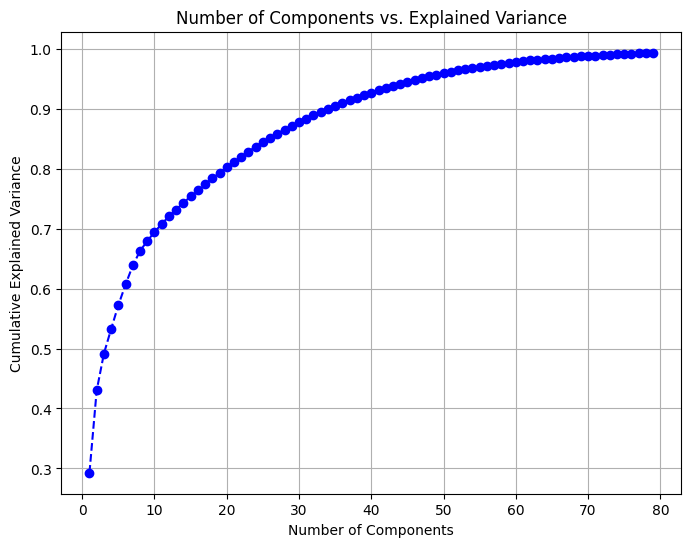

In [19]:
max_componenets = 80
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_componenets), cumulative_variance[:max_componenets-1], marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Number of Components vs. Explained Variance')
plt.grid()
plt.show()

#### Kfolds cross validation to decide on number of PCA componenets

In [20]:
n_components_range = range(20, 30)
poly_degrees = [1, 2]
mse_scores = {key: [] for key in poly_degrees}

In [21]:
for n in n_components_range:
    pca = PCA(n_components=n)
    pca_components = pca.fit_transform(X_train)
    
    for degree in poly_degrees:
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(pca_components)
        mse = -cross_val_score(model, X_poly, y_train_log, cv=kf, scoring='neg_mean_squared_error').mean()
        mse_scores[degree].append(mse)

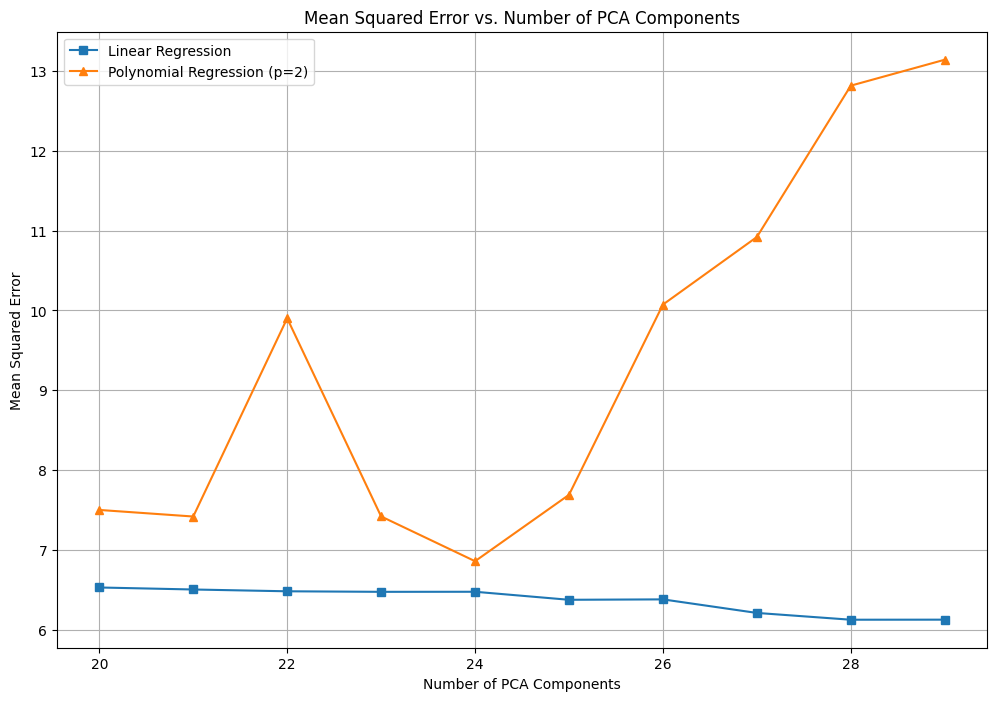

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(n_components_range, mse_scores[1], marker='s', linestyle='-', label='Linear Regression')
plt.plot(n_components_range, mse_scores[2], marker='^', linestyle='-', label='Polynomial Regression (p=2)')

plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Number of PCA Components')
plt.legend()
plt.grid()
plt.show()

#### Polynomial regression overfits -> we probably dont need a more complex model than a linear one 

#### Because there are no improvements with PCA we use some other models that work well with high dimensional data

## Lasso

In [23]:
lasso = LassoCV(alphas=np.logspace(-3, -1, 100), cv=5, random_state=42)
lasso.fit(X_train, y_train_log)

best_alpha = lasso.alpha_
print("Best alpha:", best_alpha)

Best alpha: 0.018738174228603847


In [24]:
mse_path = lasso.mse_path_.mean(axis=1)
print(f"Best MSE: {min(mse_path)}")

Best MSE: 5.9894101691874235


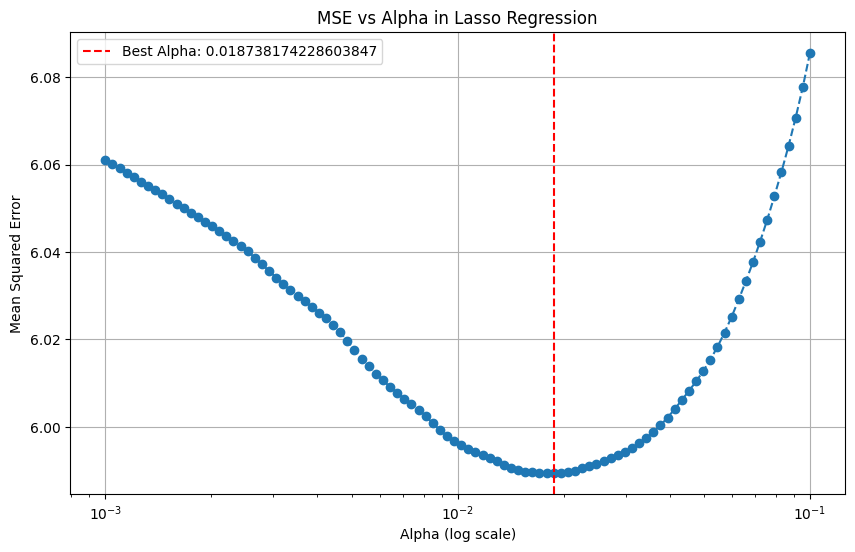

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(lasso.alphas_, mse_path, marker='o', linestyle='--')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha in Lasso Regression')
plt.axvline(best_alpha, linestyle='--', color='r', label=f'Best Alpha: {best_alpha}')
plt.legend()
plt.grid()
plt.show()

In [26]:
selected_features = np.array(X_train.columns)[lasso.coef_ != 0]
discarded_features = np.array(X_train.columns)[lasso.coef_ == 0]

print("Selected features:", selected_features)
print("Discarded features:", discarded_features)

Selected features: ['tariff.plan' 'age' 'activation.zone' 'q01.out.ch.peak'
 'q01.out.ch.offpeak' 'q01.out.val.offpeak' 'q02.ch.sms' 'q03.out.ch.peak'
 'q04.out.ch.offpeak' 'q04.ch.sms' 'q04.ch.cc' 'q05.out.dur.peak'
 'q05.out.val.offpeak' 'q06.out.ch.offpeak' 'q06.ch.cc'
 'q07.out.dur.offpeak' 'q07.in.dur.tot' 'q07.ch.cc' 'q08.out.ch.peak'
 'q08.out.ch.offpeak' 'q08.out.val.offpeak' 'q08.ch.cc' 'q09.out.ch.peak'
 'q09.out.val.peak' 'q09.out.ch.offpeak' 'q09.out.val.offpeak'
 'q09.in.ch.tot' 'q09.in.dur.tot' 'q09.ch.sms' 'q09.ch.cc'
 'payment.method_Carta di Credito'
 'payment.method_Domiciliazione Bancaria' 'sex_F' 'sex_M'
 'activation.channel_8' 'activation.channel_9' 'vas1_Y' 'vas2_Y']
Discarded features: ['q01.out.dur.peak' 'q01.out.val.peak' 'q01.out.dur.offpeak'
 'q01.in.ch.tot' 'q01.in.dur.tot' 'q01.ch.sms' 'q01.ch.cc'
 'q02.out.ch.peak' 'q02.out.dur.peak' 'q02.out.val.peak'
 'q02.out.ch.offpeak' 'q02.out.dur.offpeak' 'q02.out.val.offpeak'
 'q02.in.ch.tot' 'q02.in.dur.tot' 'q02.

### Random forests grid search

In [27]:
param_grid = {
    'n_estimators': [500, 1000],
    'max_features': ['sqrt', 0.3],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [5],
    'bootstrap': [True]
}

In [28]:
rf = RandomForestRegressor(random_state=42)

In [29]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train_log)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [None, 10],
                         'max_features': ['sqrt', 0.3], 'min_samples_leaf': [5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 1000]},
             verbose=2)

In [30]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f'Best Parameters: {best_params}')
best_mse = grid_search.best_score_
print(f'Best MSE: {best_mse:.2f}')

Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
Best MSE: 0.64


### Prediction with final model

In [31]:
y_test_log = best_model.predict(X_test)
y_test = np.exp(y_test_log) - 1
y_test = np.maximum(0, y_test)

In [32]:
np.savetxt('mySubmission.txt', y_test, fmt='%.6f')